In [ ]:
%matplotlib inline


# Expected Goals including player positions

In this lesson, we go step-by-step through the process of making expected goals model
with additional information concerning opposition player location. This tutorial
follows similar design choices as Javier Fernandez's expected goals model in 
[A framework for the fine-grained evaluation of the instantaneous expected value of soccer possessions](https://link.springer.com/article/10.1007/s10994-021-05989-6).

We will train a shallow neural network with following features

- ball location (x)
- binary variable signifying if ball was closer to the goal than the opponent's goalkeeper
- angle between the ball and the goal
- distance between the ball and the goal
- distance between the ball and the goalkeeper in y-axis
- distance between the ball and the goalkeeper
- number of opponent players inside the triangle formed between the ball location and opponent's goal posts
- number of opponent players less than 3 meters away from the ball location
- binary variable signifying if shot was a header
- expected goals based on distance to goal and angle between the ball and the goal


In [4]:
#importing necessary libraries
from mplsoccer import Sbopen
import pandas as pd
import numpy as np
import warnings 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
import random as rn
import tensorflow as tf
#warnings not visible on the course webpage
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

#setting random seeds so that the results are reproducible on the webpage
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(1)
rn.seed(1)
tf.random.set_seed(1)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Opening data
For this task we will use Statsbomb Indian Super League 2021/2022 data since it is the only dataset openly available that contains 
both event and tracking data for the entire season. We open each game and store data for the entire season in dataframes *shot_df* and *track_df*.
Also, we change yards to meters. In the end we filter open play shots and remove shots without a goalkeeper tracked.



In [5]:
parser = Sbopen()
#get list of games during Indian Super League season
df_match = parser.match(competition_id=1238, season_id=108)

matches = df_match.match_id.unique()

shot_df = pd.DataFrame()
track_df = pd.DataFrame()
#store data in one dataframe
for match in matches:
    #open events
    df_event = parser.event(match)[0]
    #open 360 data
    df_track = parser.event(match)[2]
    #get shots
    shots = df_event.loc[df_event["type_name"] == "Shot"]
    shots.x = shots.x.apply(lambda cell: cell*105/120)
    shots.y = shots.y.apply(lambda cell: cell*68/80)
    df_track.x = df_track.x.apply(lambda cell: cell*105/120)
    df_track.y = df_track.y.apply(lambda cell: cell*68/80)
    #append event and trackings to a dataframe
    shot_df = pd.concat([shot_df, shots], ignore_index = True)
    track_df = pd.concat([track_df, df_track], ignore_index = True)

#reset indicies    
shot_df.reset_index(drop=True, inplace=True)    
track_df.reset_index(drop=True, inplace=True)  
#filter out non open-play shots  
shot_df = shot_df.loc[shot_df["sub_type_name"] == "Open Play"]
#filter out shots where goalkeeper was not tracked
gks_tracked = track_df.loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"]['id'].unique()
shot_df = shot_df.loc[shot_df["id"].isin(gks_tracked)]

In [14]:
track_df

,teammate,match_id,id,x,y,player_id,player_name,position_id,position_name,event_freeze_id
0,True,3827767,f4889f42-cf51-4c27-8c8d-d57040b17ce1,85.4000,44.285,125109,Mohammad Yasir,12,Right Midfield,1
1,True,3827767,f4889f42-cf51-4c27-8c8d-d57040b17ce1,89.7750,34.765,26186,Bartholomew Owogbalor Ogbeche,24,Left Center Forward,2
2,True,3827767,f4889f42-cf51-4c27-8c8d-d57040b17ce1,90.2125,30.855,33419,Joel Joseph Chianese,22,Right Center Forward,3
3,True,3827767,f4889f42-cf51-4c27-8c8d-d57040b17ce1,90.3000,28.645,26675,João Victor de Albuquerque Bruno,11,Left Defensive Midfield,4
4,True,3827767,f4889f42-cf51-4c27-8c8d-d57040b17ce1,87.4125,18.530,166022,Aniket Anil Jadhav,16,Left Midfield,5
...,...,...,...,...,...,...,...,...,...,...
41653,False,3813264,aca6baf6-a0e0-4a7a-b60c-e785525cefed,91.7875,31.620,124772,Pritam Kotal,3,Right Center Back,6
41654,False,3813264,aca6baf6-a0e0-4a7a-b60c-e785525cefed,87.0625,28.645,163343,Lenny Rodrigues,9,Right Defensive Midfield,7
41655,False,3813264,aca6baf6-a0e0-4a7a-b60c-e785525cefed,92.1375,17.595,163339,Prabir Das,6,Left Back,8
41656,True,3813264,aca6baf6-a0e0-4a7a-b60c-e785525cefed,91.3500,24.905,26186,Bartholomew Owogbalor Ogbeche,19,Center Attacking Midfield,9


## Feature engineering
In this section we will create features as described before. They will be stored in *model_vars* dataframe. 
We suggest reading the code comments to understand this part of tutorial better.



In [6]:
#take important variables from shot dataframe
model_vars = shot_df[["id", "index", "x", "y"]]
#get the dependent variable
model_vars["goal"] = shot_df.outcome_name.apply(lambda cell: 1 if cell == "Goal" else 0)
#change the dependent variable to object for basic xG modelling
model_vars["goal_smf"] = model_vars["goal"].astype(object)
# ball location (x)
model_vars['x0'] = model_vars.x
# x to calculate angle and distance
model_vars["x"] = model_vars.x.apply(lambda cell: 105-cell)
# c to calculate angle and distance between ball and the goal as in Lesson 2
model_vars["c"] = model_vars.y.apply(lambda cell: abs(34-cell))
#calculating angle and distance as in Lesson 2
model_vars["angle"] = np.where(np.arctan(7.32 * model_vars["x"] / (model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)) >= 0, np.arctan(7.32 * model_vars["x"] /(model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)), np.arctan(7.32 * model_vars["x"] /(model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)) + np.pi)*180/np.pi
model_vars["distance"] = np.sqrt(model_vars["x"]**2 + model_vars["c"]**2)

#calculating basic xG using logistic regression
def params(df):
    test_model = smf.glm(formula="goal_smf ~ angle + distance", data=df,
                               family=sm.families.Binomial()).fit()
    #print summary
    return test_model.params
def calculate_xG(sh, b):
   bsum=b[0]
   for i,v in enumerate(["angle", "distance"]):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum))
   return xG

#expected goals based on distance to goal and angle between the ball and the goal
b = params(model_vars)
model_vars["xg_basic"]= model_vars.apply(calculate_xG, b = b, axis=1)

#ball_goalkeeper distance
def dist_to_gk(test_shot, track_df):
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #check goalkeeper position 
    gk_pos = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"][["x", "y"]]
    #calculate distance from event to goalkeeper position
    dist = np.sqrt((test_shot["x"] - gk_pos["x"])**2 + (test_shot["y"] - gk_pos["y"])**2)
    return dist.iloc[0]
#store distance from event to goalkeeper position in a dataframe 
model_vars["gk_distance"] = shot_df.apply(dist_to_gk, track_df = track_df, axis = 1)


#ball goalkeeper y axis
def y_to_gk(test_shot, track_df):
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #calculate distance from event to goalkeeper position
    gk_pos = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"][["y"]]
    #calculate distance from event to goalkeeper position in y axis
    dist = abs(test_shot["y"] - gk_pos["y"])
    return dist.iloc[0]

#store distance in y axis from event to goalkeeper position in a dataframe 
model_vars["gk_distance_y"] = shot_df.apply(y_to_gk, track_df = track_df, axis = 1)

#number of players less than 3 meters away from the ball
def three_meters_away(test_shot, track_df):
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #get all opposition's player location
    player_position = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False][["x", "y"]]
    #calculate their distance to the ball
    dist = np.sqrt((test_shot["x"] - player_position["x"])**2 + (test_shot["y"] - player_position["y"])**2)
    #return how many are closer to the ball than 3 meters
    return len(dist[dist<3])
#store number of opposition's players closer than 3 meters in a dataframe 
model_vars["close_players"] = shot_df.apply(three_meters_away, track_df = track_df, axis = 1)

#number of players inside a triangle
def players_in_triangle(test_shot, track_df):
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #get all opposition's player location
    player_position = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False][["x", "y"]]
    #checking if point inside a triangle 
    x1 = 105
    y1 = 34 - 7.32/2
    x2 = 105
    y2 = 34 + 7.32/2
    x3 = test_shot["x"]
    y3 = test_shot["y"]
    xp = player_position["x"]
    yp = player_position["y"]
    c1 = (x2-x1)*(yp-y1)-(y2-y1)*(xp-x1)
    c2 = (x3-x2)*(yp-y2)-(y3-y2)*(xp-x2)
    c3 = (x1-x3)*(yp-y3)-(y1-y3)*(xp-x3)
    #get number of players inside a triangle 
    return len(player_position.loc[((c1<0) & (c2<0) & (c3<0)) | ((c1>0) & (c2>0) & (c3>0))])

#store number of opposition's players inside a triangle in a dataframe 
model_vars["triangle"] = shot_df.apply(players_in_triangle, track_df = track_df, axis = 1)

#goalkeeper distance to goal
def gk_dist_to_goal(test_shot, track_df):
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #get goalkeeper position
    gk_pos = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"][["x", "y"]]
    #calculate their distance to goal
    dist = np.sqrt((105 -gk_pos["x"])**2 + (34 - gk_pos["y"])**2)
    return dist.iloc[0]
    
#store opposition's goalkeeper distance to goal in a dataframe 
model_vars["gk_dist_to_goal"] = shot_df.apply(gk_dist_to_goal, track_df = track_df, axis = 1)
#create binary varibale 1 if ball is closer to the goal than goalkeeper
model_vars["is_closer"] = np.where(model_vars["gk_dist_to_goal"] > model_vars["distance"], 1, 0)
#create binary variable 1 if header
model_vars["header"] = shot_df.body_part_name.apply(lambda cell: 1 if cell == "Head" else 0)


#store dependent variable in a numpy array
y = model_vars["goal"].values
#store independent variables in a numpy array
X = model_vars[["x0", "is_closer", "angle", "distance", "gk_distance", "gk_distance_y", "triangle", "close_players", "header", "xg_basic"]].values

## Training neural network 
With the features created we can now train a neural network. We split the data 60% training, 20% validation and 20% test. Then, we scale inputs. 
As the next step, we create a neural network model. It follows similar design choices as Javier Fernandez's one. 2 dense layers sized 10 followed 
by a ReLU activation and a final layer size 1 with sigmoid activation to compute the probabilities. Our model optimizes the Brier score using Adam
optimizer with learning rate 0.001 default betas. We use as suggested early stopping with minimum delta 1e-5 and batch size 16. However, we also use patience
equal to 50 not to stop the first time when the validation loss is not changing.



Epoch 1/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8556 - loss: 0.1912 - val_accuracy: 0.8974 - val_loss: 0.1098
Epoch 2/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.9062 - loss: 0.1005 - val_accuracy: 0.8974 - val_loss: 0.0929
Epoch 3/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.9062 - loss: 0.0878 - val_accuracy: 0.8974 - val_loss: 0.0895
Epoch 4/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.9062 - loss: 0.0851 - val_accuracy: 0.8974 - val_loss: 0.0870
Epoch 5/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.9062 - loss: 0.0834 - val_accuracy: 0.8974 - val_loss: 0.0844
Epoch 6/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.9062 - loss: 0.0817 - val_accuracy: 0.8974 - val_loss: 0.0817
Epoch 7/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.9065 - loss: 0.0800 - val_accuracy: 0.9009 - val_loss: 0.0796
Epoch 8/1000
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.9074 - l

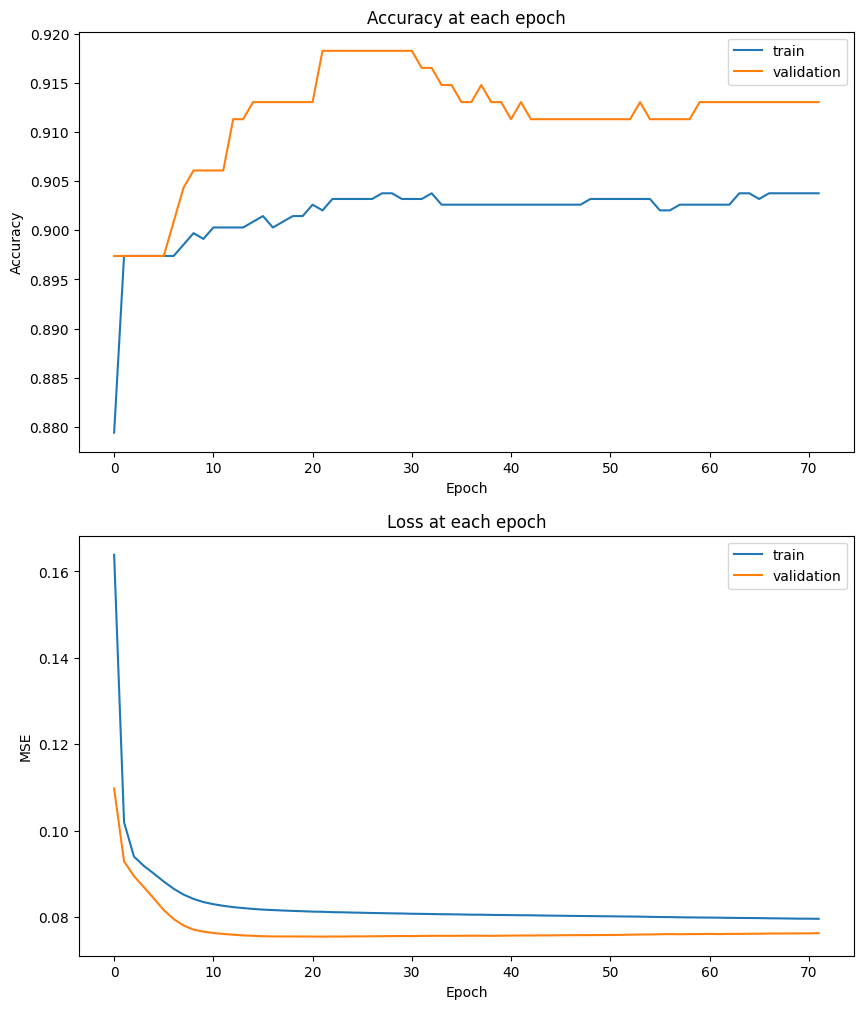

In [7]:
#import machine learning libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


#spllit the data to train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6, random_state = 123, stratify = y)
X_cal, X_val, y_cal, y_val  = train_test_split(X_test, y_test, train_size = 0.5, random_state = 123, stratify = y_test)
#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_cal = scaler.transform(X_cal)

#creating a function with a model architecture
def create_model():
    model = Sequential([
        Dense(10, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1, activation = 'sigmoid'),
    ])
    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss="mean_squared_error" , metrics=['accuracy'])
    return model

#create model
model = create_model()
#create an early stopping object
callback = EarlyStopping(min_delta=1e-5, patience = 50, mode = "min", monitor = "val_loss", restore_best_weights=True)
#fit the model 
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, verbose=1, batch_size=16, callbacks = [callback])    

fig, axs = plt.subplots(2, figsize=(10,12))
#plot training history - accuracy
axs[0].plot(history.history['accuracy'], label='train')   
axs[0].plot(history.history['val_accuracy'], label='validation')
axs[0].set_title("Accuracy at each epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

#plot training history - loss function
axs[1].plot(history.history['loss'], label='train')   
axs[1].plot(history.history['val_loss'], label='validation')
axs[1].legend()
axs[1].set_title("Loss at each epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("MSE")
plt.show()

## Assessing our model
To assess our model, we calculate ROC AUC and investigate calibration curves. From the plots we can see that some of higher probabilities are
underestimated by our model, but these are satisfactory results given the number of data we have and a shallow network. Also, we calculate Brier score
on unseen data. It amounts to 0.08, which is a good score. 



18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


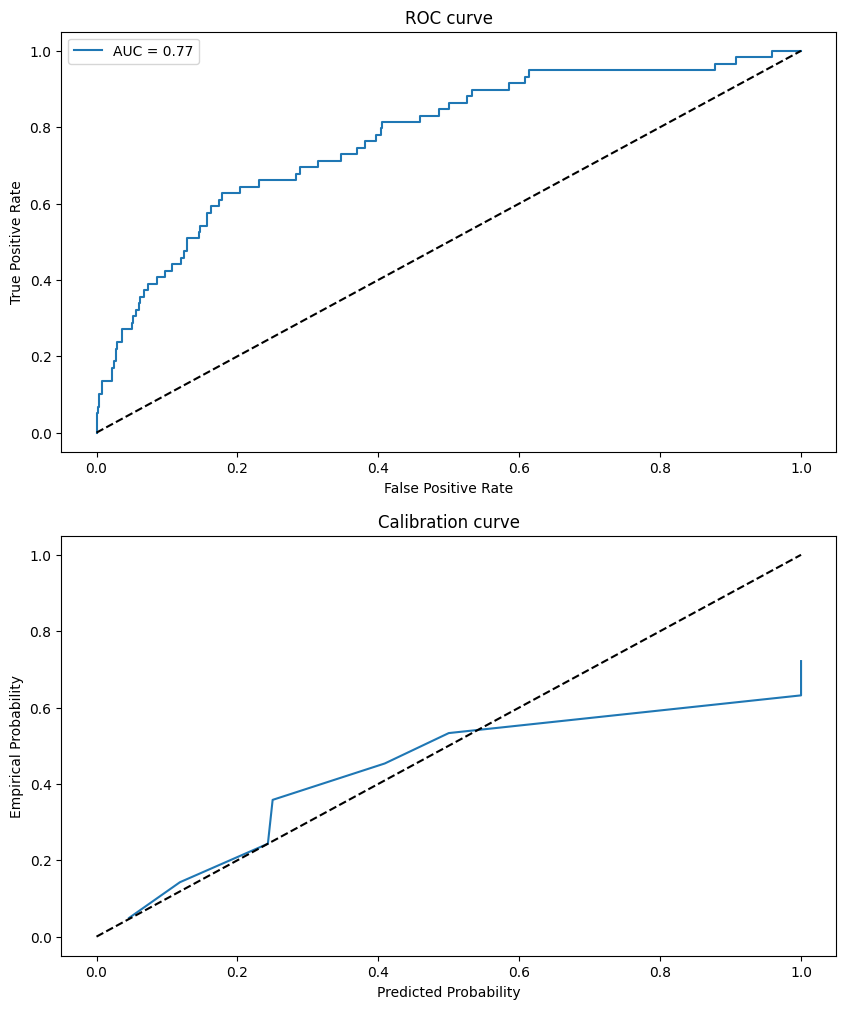

Brier score 0.08019957763710402


In [8]:
#ROC CURVE
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
fig, axs = plt.subplots(2, figsize=(10,12))
y_pred = model.predict(X_cal)
fpr, tpr, _ = roc_curve(y_cal,  y_pred)
auc = roc_auc_score(y_cal, y_pred)
axs[0].plot(fpr,tpr,label= "AUC = " + str(auc)[:4])
axs[0].plot([0, 1], [0, 1], color='black', ls = '--')
axs[0].legend()
axs[0].set_ylabel('True Positive Rate')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_title('ROC curve')

#CALIBRATION CURVE
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_cal, y_pred, n_bins=10)
axs[1].plot(prob_true, prob_pred)
axs[1].plot([0, 1], [0, 1], color='black', ls = '--')
axs[1].set_ylabel('Empirical Probability')
axs[1].set_xlabel('Predicted Probability')
axs[1].set_title("Calibration curve")
plt.show()
#Brier score
print("Brier score", brier_score_loss(y_cal, y_pred))

## Calculating xG using our model during UEFA Euro 2020
With a trained model, we can now apply it on a dataset of our choice. We chose UEFA Euro 2020. First, we store the data the same way as for Indian 
Super League. Then, we apply the same data transformations as on our training dataset. As the next step we scale our data and make predictions on them.
Then, we try to find out 5 players that accumulated the highest open play Expected Goals during the tournament.



In [9]:
#getting trackings and events for UEFA Euro the same way as we did for Indian Super League
df_match2 = parser.match(competition_id=55, season_id=43)
#get array of match ids
matches2 = df_match2.match_id.unique()
shot_df2 = pd.DataFrame()
track_df2 = pd.DataFrame()
#for each match store shots and trackings in dataframes for the entire season
for match in matches2:
    df_event = parser.event(match)[0]
    df_track = parser.event(match)[2]
    shots = df_event.loc[df_event["type_name"] == "Shot"]
    shots.x = shots.x.apply(lambda cell: cell*105/120)
    shots.y = shots.y.apply(lambda cell: cell*68/80)
    df_track.x = df_track.x.apply(lambda cell: cell*105/120)
    df_track.y = df_track.y.apply(lambda cell: cell*68/80)
    
    shot_df2 = pd.concat([shot_df2, shots], ignore_index = True)
    track_df2 = pd.concat([track_df2, df_track], ignore_index = True)

#reset indicies and remove shots that were not open play or when the goalkeeper was not tracked
shot_df2 = shot_df2.loc[shot_df2["sub_type_name"] == "Open Play"]   
shot_df2.reset_index(drop=True, inplace=True)
track_df2.reset_index(drop=True, inplace=True)
gks_tracked2 = track_df2.loc[track_df2["teammate"] == False].loc[track_df2["position_name"] == "Goalkeeper"]['id'].unique()
shot_df2 = shot_df2.loc[shot_df2["id"].isin(gks_tracked2)]

#DATA WRANGLING. DESCRIPTION OF THESE STEPS CAN BE FOUND IN FEATURE ENGINEERING PART
model_vars2 = shot_df2[["id", "index", "x", "y"]]
model_vars2["goal"] = shot_df2.outcome_name.apply(lambda cell: 1 if cell == "Goal" else 0)
model_vars2["goal_smf"] = model_vars2["goal"].astype(object)
model_vars2['x0'] = model_vars2.x
model_vars2["x"] = model_vars2.x.apply(lambda cell: 105-cell)
model_vars2["c"] = model_vars2.y.apply(lambda cell: abs(34-cell))
model_vars2["angle"] = np.where(np.arctan(7.32 * model_vars2["x"] / (model_vars2["x"]**2 + model_vars2["c"]**2 - (7.32/2)**2)) >= 0, np.arctan(7.32 * model_vars2["x"] /(model_vars2["x"]**2 + model_vars2["c"]**2 - (7.32/2)**2)), np.arctan(7.32 * model_vars2["x"] /(model_vars2["x"]**2 + model_vars2["c"]**2 - (7.32/2)**2)) + np.pi)*180/np.pi
model_vars2["distance"] = np.sqrt(model_vars2["x"]**2 + model_vars2["c"]**2)
model_vars2["xg_basic"]= model_vars2.apply(calculate_xG, b = b, axis=1)
model_vars2["gk_distance"] = shot_df2.apply(dist_to_gk, track_df = track_df2, axis = 1)
model_vars2["gk_distance_y"] = shot_df2.apply(y_to_gk, track_df = track_df2, axis = 1)
model_vars2["triangle"] = shot_df2.apply(players_in_triangle, track_df = track_df2, axis = 1)
model_vars2["close_players"] = shot_df2.apply(three_meters_away, track_df = track_df2, axis = 1)
model_vars2["gk_dist_to_goal"] = shot_df2.apply(gk_dist_to_goal, track_df = track_df2, axis = 1)
model_vars2["is_closer"] = np.where(model_vars2["gk_dist_to_goal"] > model_vars2["distance"], 1, 0)
model_vars2["header"] = shot_df2.body_part_name.apply(lambda cell: 1 if cell == "Head" else 0)

#store data in a matrix
X_unseen = model_vars2[["x0", "is_closer", "angle", "distance", "gk_distance", "gk_distance_y", "triangle", "close_players", "header", "xg_basic"]].values
#scale data
X_unseen = scaler.transform(X_unseen)
#make predictions
xgs_euro = model.predict(X_unseen)
#find out which 5 players had the highest xG
shot_df2["our_xG"] = xgs_euro
shot_df2.groupby(["player_name"])["our_xG"].sum().sort_values(ascending = False)[:5].reset_index()

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


,player_name,our_xG
0,Álvaro Borja Morata Martín,2.894736
1,Harry Kane,2.719203
2,Cristiano Ronaldo dos Santos Aveiro,2.480134
3,Kai Havertz,2.356027
4,Gerard Moreno Balaguero,2.349644
